# Génération de gaussienne par modèle de diffusion

<h2>Importation</h2>

In [51]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

<h2>Affichage des points</h2>

<p>Fonction qui prend en argument des points sous forme de tableau numpy ou bien de tensor et qui les affiche</p>

In [52]:
def show_points(X):
    nb_points, dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot = 0
    for d1 in range(dim):
        for d2 in range(d1 + 1, dim):
            xs, ys = [], []
            nb_plot += 1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1, dim**2, nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs, ys, marker='+')
    plt.show()
    return

<h2>Modèles</h2>

<p>On utilise différent modèles : 
    <ul>
        <li>Le modèle Net. C'était notre modèle initiale qui contient seulement quelques couches linéaires</li>
        <li>DiffusionBlock : Contient le block du milieu pour le modèle DiffusionModel</li>
        <li>DiffusionModel : Contient un modèle assez similaire à celui utilisé dans le notebook</li>
        <li>Diff : Modèle qui va gérer toute la diffusion</li>
</p>

In [53]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t = t.reshape(-1, 1)
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 1e-4, beta_end = 0.1, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.network = network
        self.device = device
        
        s = 0.008
        timesteps = torch.tensor(range(0, num_timesteps), dtype=torch.float32)
        schedule = torch.cos((timesteps / num_timesteps + s) / (1 + s) * torch.pi / 2)**2
        self.alphas_cumprod = schedule / schedule[0]
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod)**0.5
        self.betas = 1 - self.alphas_cumprod / torch.concatenate([self.alphas_cumprod[0:1], self.alphas_cumprod[0:-1]])
        self.alphas = 1 - self.betas

    def plot_alphacumprods(self):
        #Fonction qui permet d'afficher les beta et de vérifier que la courbe a à peu près la forme voulue
        plt.plot(torch.arange(1, num_timesteps + 1), self.alphas_cumprod)
        plt.show()
        
    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        return x_start * s1 + x_noise * s2
        
    def reverse(self,x,t):
        return self.network(x,t)
        
    def step(self, model_output, timestep, sample):
        # model_output = epsilon_theta, timestep = t, sample = x_t
        # but: avoir x_{t-1}
        t = timestep
        coef_eps_t = ((1 - self.alphas[t]) / self.sqrt_one_minus_alphas_cumprod[t]).reshape(-1,1).to(device)
        coef_first_t = (1 / self.alphas[t] ** 0.5).reshape(-1,1).to(device)
        pred_prev_sample = (coef_first_t * (sample - coef_eps_t * model_output)).to(device)
        variance = 0
        if t > 1:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

<h2>Training loop</h2>
<p>La training loop est simple, on optimise pour apprendre le bruit aouté à chaque étape</p>

In [54]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    
    for epoch in range(num_ep):
        if epoch != 0 and epoch % 10 == 0:
            print(f"New epoch ({epoch}) last losses: {losses[-1]}, average lost on the last ten epoch : {sum(losses[-10:]) / 10}")
        model.train()
        l = 0
        
        for step, batch in enumerate(dataloader):
            batch = batch.to(device) # les x0 avec lesquels je vais me train.
            eps = torch.randn(batch.shape).to(device) # un epsilon par x0 pour les flouter
            timesteps = torch.randint(model.num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, eps, timesteps) # xt
            noise_pred = model.reverse(noisy, timesteps) # on essaye de prédire le epsilon à partir des images floutées.
            loss = F.mse_loss(noise_pred, eps)
            optim.zero_grad()
            loss.backward()
            optim.step()
            l += loss.detach().item()
            global_step += 1
        losses.append(l / len(dataloader))
        
    plt.plot(torch.arange(num_ep), losses)
    plt.show()

<h2>Dataset</h2>
<p>On créer une classe MultivariateNormalDataset qui permet de générer des points selon différentes distributions gaussiennes. A terme, le but serait d'avoir différentes classe permettant d'avoir différents types de distributions afin de vérifier que ça apprend bien à chaque fois</p>

In [55]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        mean = mean.expand(num_samples, -1)
        std = std.expand(num_samples, -1)
        self.data = torch.normal(mean=mean, std=std)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

<h2>Génération de points</h2>

In [98]:
def genere_un_point(model):
    sample = torch.randn(dim).unsqueeze(0).to(device)
    evolution = sample.clone().detach()
    model.eval()
    with torch.no_grad():
        timesteps = list(range(1, model.num_timesteps))[::-1]
        for t in timesteps:
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample)
            evolution = torch.concatenate((evolution, sample))
            # p(xt-1 | xt), prend en entrée le epislon_theta, et le temps où on est, et la version floutée.
    return sample, evolution

def genere_points(nb_points, model):
    X = torch.tensor([])
    X = X.to('cpu')
    evolution_X = torch.tensor([])
    evolution_X = evolution_X.to('cpu')
    
    for i in range(nb_points):
        if i % 100 ==0 and i != 0: 
            print(f"generated {i} points.")
        x, evolution_x = genere_un_point(model)
        x = x.to('cpu')
        evolution_x = evolution_x.to('cpu')
        X = torch.concatenate((X, x))
        evolution_X = torch.concatenate((evolution_X, evolution_x.reshape(1, -1, 2)), axis=0)

    return X, evolution_X

<h2>Routine d'entraînement</h2>
<p>C'est ici qu'on définit notre routine d'entraîenement et d'affichage des résultats qui est globalement la même. Elle est composée de
<ul>
    <li>Entraînement du modèle</li>
    <li>Affichage des résultats sous la forme de plusieurs étapes qui montre comment les points vont se déplacer petit à petit vers la distribution voulue</li>
</ul>
</p>

In [122]:
def routine(network, model, dataset, dataloader, num_epochs, num_timesteps, num_points_genere, nb_etape_affiche, figsize=(16,4), lr=1e-3):
    
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    training_loop(model, dataloader, optimizer, num_epochs, num_timesteps)

    X, evolution_X = genere_points(num_points_genere, model)
    #show_points(X)

    fig, axes = plt.subplots(1, nb_etape_affiche, figsize=figsize)
    #positions = [int(i * (num_timesteps - 1) / (nb_etape_affiche - 1)) for i in range(nb_etape_affiche)]
    positions = [i for i in range(num_timesteps - nb_etape_affiche, num_timesteps)]

    for (i, pos) in enumerate(positions):
        axes[i].scatter(dataset.data[:, 0], dataset.data[:, 1], color='blue', marker='+')
        axes[i].scatter(evolution_X[:, pos, 0], evolution_X[:, pos, 1], color='red', marker='+')

    plt.tight_layout()
    plt.show()

    return X

<h2>Mise en pratique</h2>
<p>On va entraîner notre modèle sur des distributions de difficultés variables. A noter qu'il semble qu'à chaque fois il est nécéssaire de redéfinir toutes les constantes beta_start, beta_end, nombre de sample et nombre d'étapes de bruitage parce que c'est directement lié au dataset qu'on essaie de générer. En effet, il faut faire d'avoir le bon nombre de num_steps de sorte que ça suffise pour transformer notre distribution initiale en quelques chose de gaussien centré en 0 et de variance 1, mais pas plus car autrement ça fausse les résultats à la fin. Pour cela, on commence par créer une fonction plot_full_noise qui permet d'appliquer tout le bruit sur notre dataset de départ et de voir si la pahse de bruitage est suffisament longue</p>

In [58]:
def get_full_noise(dataset, model):
    noise = torch.randn(dataset.data.shape).to(device) # un epsilon par x0 pour les flouter
    timesteps = torch.full((dataset.data.shape[0],), model.num_timesteps - 1).long().to(device)
    noisy = model.add_noise(dataset.data, noise, timesteps)
    return noisy 

<h3>Gaussiennes</h3>

In [111]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

#On commence avec une gaussienne centrée en (6, 6) et avec une variance de (2, 2)
dim=2
mean = 4*torch.ones((dim,))
std = 2*torch.ones((dim,))

dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

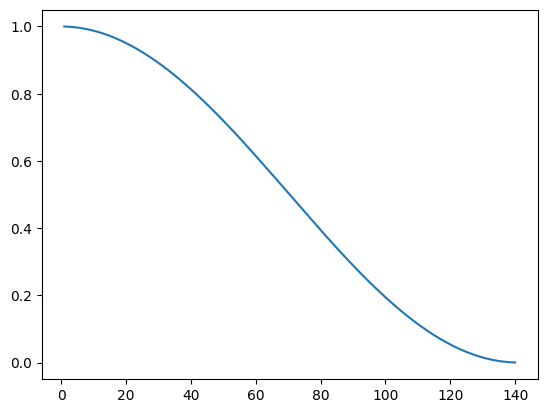

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-1): 2 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)


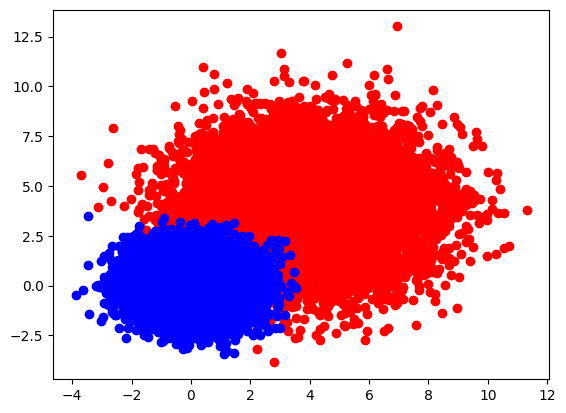

Moyenne de la distribution d'entraînement : tensor([3.9639, 3.9930])
Variance de la distribution initiale : tensor([2.0117, 2.0174])
Moyenne de la distribution bruitée : tensor([0.0456, 0.0316])
Variance de la distribution bruitée : tensor([1.0030, 0.9971])


In [112]:
num_epochs = 1000
num_timesteps = 140

network = DiffusionModel(dim, nblocks=2, nunits=64).to(device)
model = Diff(network,num_timesteps,device = device)
model.plot_alphacumprods()
print(network)

plt.scatter(dataset.data[:, 0], dataset.data[:, 1], color='red')
noisy = get_full_noise(dataset, model)
plt.scatter(noisy[:, 0], noisy[:, 1], color='blue')
plt.show()

print(f"Moyenne de la distribution d'entraînement : {torch.mean(dataset.data, axis=0)}")
print(f"Variance de la distribution initiale : {torch.std(dataset.data, axis=0)}")
print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

140
New epoch (10) last losses: 0.9505069971084594, average lost on the last ten epoch : 1.9563522326946259
New epoch (20) last losses: 0.9178976774215698, average lost on the last ten epoch : 0.9289153563976289
New epoch (30) last losses: 0.8831791281700134, average lost on the last ten epoch : 0.8983449244499206
New epoch (40) last losses: 0.845618486404419, average lost on the last ten epoch : 0.8641263401508331
New epoch (50) last losses: 0.827643883228302, average lost on the last ten epoch : 0.8317757427692414
New epoch (60) last losses: 0.7809391736984252, average lost on the last ten epoch : 0.8065382492542266
New epoch (70) last losses: 0.7808871746063233, average lost on the last ten epoch : 0.7876112377643586
New epoch (80) last losses: 0.7624437928199768, average lost on the last ten epoch : 0.7751293730735779
New epoch (90) last losses: 0.7394241690635681, average lost on the last ten epoch : 0.7566397321224213
New epoch (100) last losses: 0.7350852847099304, average lost 

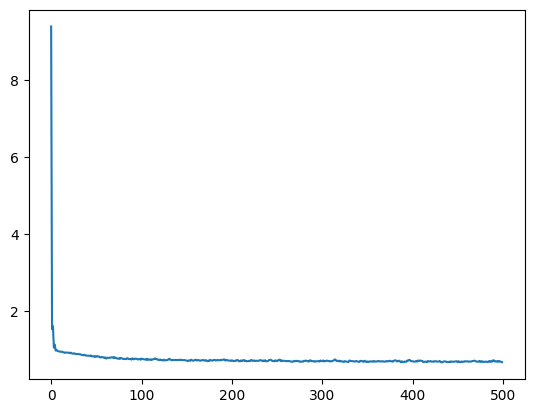

generated 100 points.
generated 200 points.
generated 300 points.
generated 400 points.
generated 500 points.
generated 600 points.
generated 700 points.
generated 800 points.
generated 900 points.


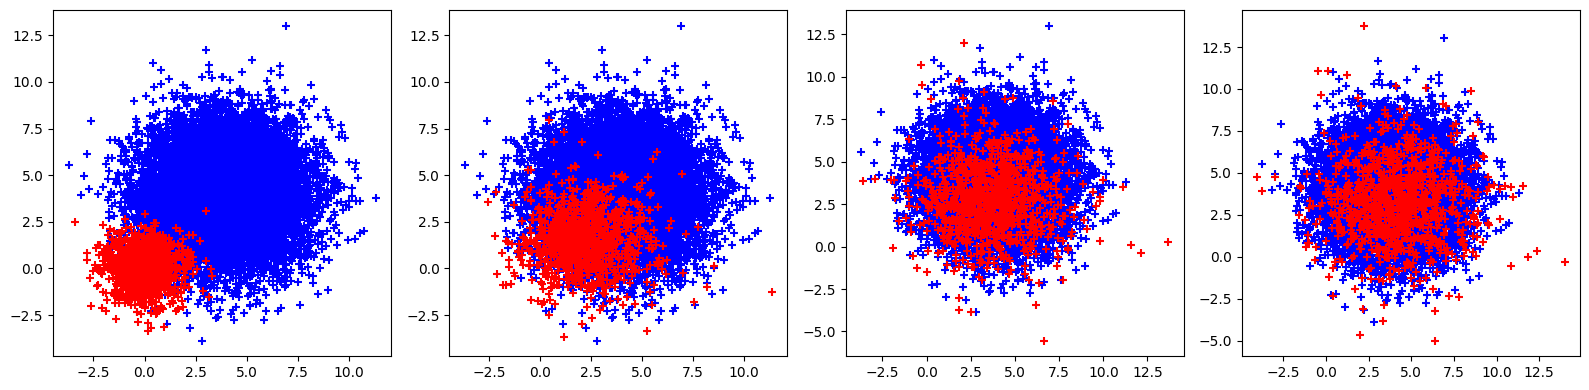

Moyenne de la distribution obtenue : tensor([4.2006, 3.2580])
Variance de la distribution obtenue : tensor([2.2938, 2.2227])


In [113]:
X = routine(network, model, dataset, dataloader, 500, num_timesteps, 1000, 4)
print(f"Moyenne de la distribution obtenue : {torch.mean(X, axis=0)}")
print(f"Variance de la distribution obtenue : {torch.std(X, axis=0)}")

<h2>Distribution en spirale</h2>
<p>Distribution en forme de spirale qui normalement devrait être un peu plus dure à apprendre. Petite remarque : jusqu'à maintenant on ne faisait pas le classique centralisation + normalisation avant d'apprendre parce que ça aurait un peu faussé tout l'intérêt de nos distributions précédentes, mais à partir de maintenant il faut le faire</p>

In [133]:
class SpiraleDataset(Dataset):
    def __init__(self, theta_max, a, b, num_samples):
        theta = torch.rand(num_samples) * theta_max
        radius = a + b * theta
        
        self.data = torch.stack((radius * torch.cos(theta), radius * torch.sin(theta)), dim=1)
        self.data -= torch.mean(self.data, axis=0)
        self.data /= torch.std(self.data, axis=0)
        
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

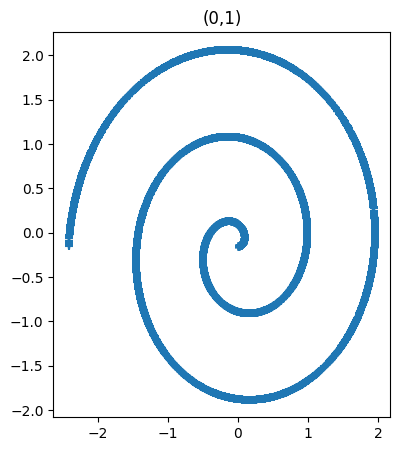

In [134]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

dataset_spirale = SpiraleDataset(5 * torch.pi, 0, 5, num_samples)
show_points(dataset_spirale.data)
dataloader_spirale = DataLoader(dataset_spirale, batch_size=batch_size, shuffle=True)

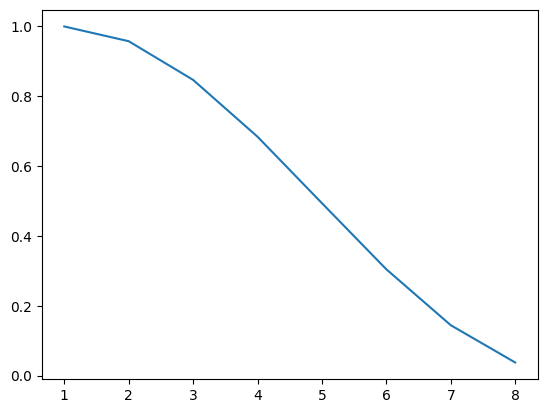

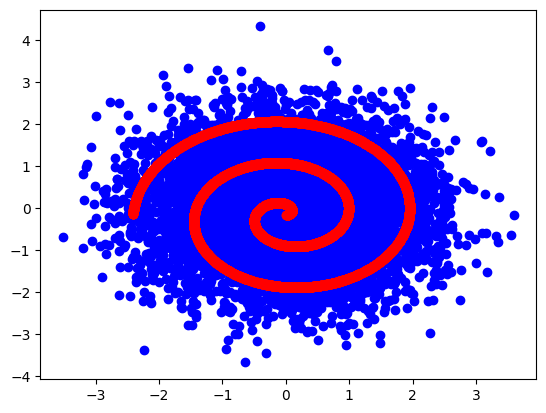

In [137]:
num_epochs = 1000
num_timesteps = 8

network_spirale = DiffusionModel(dim, nblocks=4, nunits=64).to(device)
model_spirale = Diff(network_spirale, num_timesteps, device = device)
model_spirale.plot_alphacumprods()

noisy = get_full_noise(dataset_spirale, model_spirale)
plt.scatter(noisy[:, 0], noisy[:, 1], color='blue')
plt.scatter(dataset_spirale.data[:, 0], dataset_spirale.data[:, 1], color='red')
plt.show()

#print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
#print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

New epoch (10) last losses: 0.6972041487693786, average lost on the last ten epoch : 0.8195814454555512
New epoch (20) last losses: 0.6590253591537476, average lost on the last ten epoch : 0.6701923263072967
New epoch (30) last losses: 0.6710752964019775, average lost on the last ten epoch : 0.6685606384277344
New epoch (40) last losses: 0.6696229577064514, average lost on the last ten epoch : 0.6614813506603241
New epoch (50) last losses: 0.6619444727897644, average lost on the last ten epoch : 0.6637565422058105
New epoch (60) last losses: 0.6634312391281127, average lost on the last ten epoch : 0.6591884076595307
New epoch (70) last losses: 0.6611826777458191, average lost on the last ten epoch : 0.6575370180606842
New epoch (80) last losses: 0.6730506300926209, average lost on the last ten epoch : 0.6572405672073364
New epoch (90) last losses: 0.6537297487258911, average lost on the last ten epoch : 0.6555093026161194
New epoch (100) last losses: 0.6537099838256836, average lost on

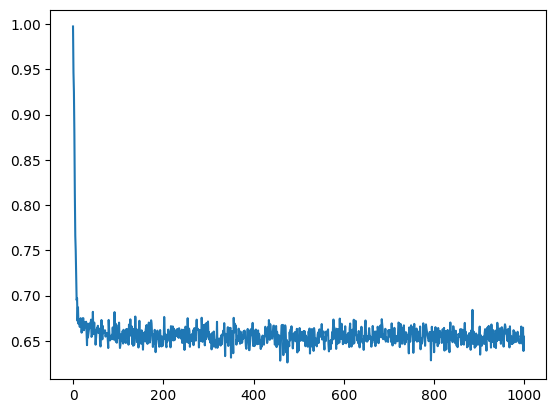

generated 100 points.
generated 200 points.
generated 300 points.
generated 400 points.
generated 500 points.
generated 600 points.
generated 700 points.
generated 800 points.
generated 900 points.


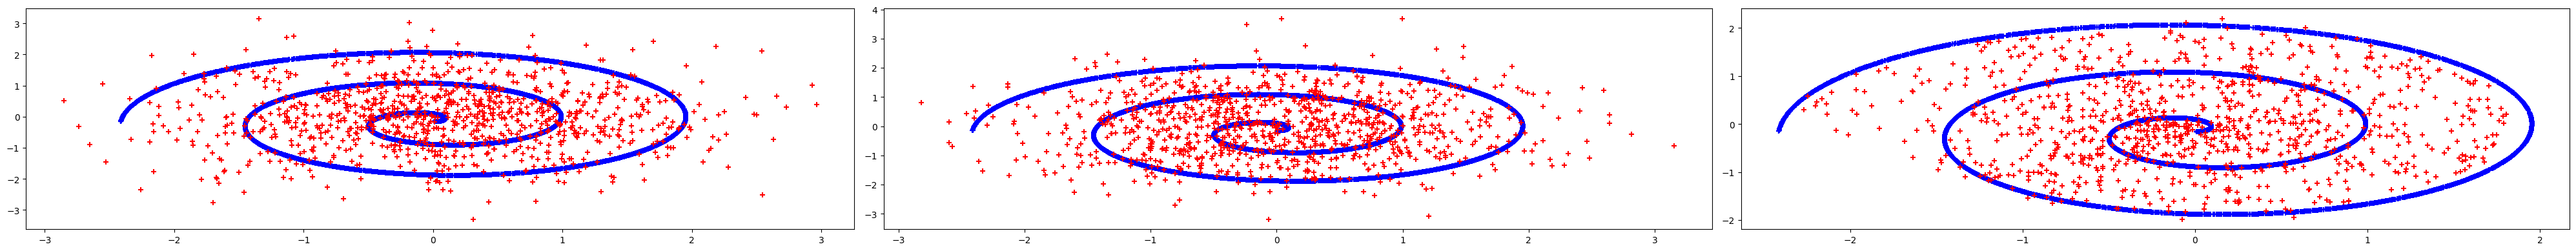

In [136]:
X = routine(network_spirale, model_spirale, dataset_spirale, dataloader_spirale, 1000, num_timesteps, 1000, 8, figsize=(40, 4))